# Pre-processing of the ALFA dataset

Reference:

Keipour, A., Mousaei, M., & Scherer, S. (2021). Alfa: A dataset for uav fault and anomaly detection. The International Journal of Robotics Research, 40(2-3), 515-520.
        

Dataset source: 

[ALFA: A Dataset for UAV Fault and Anomaly Detection](https://kilthub.cmu.edu/articles/dataset/ALFA_A_Dataset_for_UAV_Fault_and_Anomaly_Detection/12707963)

## Short description of some useful topics (signals)

Topics (Signals):

* mavros-time_reference:
    * stamp is system time for which measurement was valid
    * time_ref corresponding time from this external source
    * frame_id is not used
* mavros-imu-atm_pressure:
    * Air pressure (Atmospheric pressure)
    * fluid_pressure is absolute pressure reading in Pascals
* mavros-imu-data:
    * This is a message to hold data from an IMU (Inertial Measurement Unit)
    * orientation x, y, z
* mavros-imu-temperature:
    * Temperature reported by FCU (usually from barometer)
* mavros-vfr_hud:
    * HUD: Head-up Display
    * std_msgs/Header header
    * float32 airspeed # m/s
    * float32 groundspeed # m/s
    * int16 heading # degrees 0..360
    * float32 throttle # normalized to 0.0..1.0
    * float32 altitude # MSL (Mean Sea Level) 
    * float32 climb # current climb rate m/s
* mavros-wind_estimation
    * linear x, y, z
* mavros-nav_info-errors:
    * alt_error Altitude errors
    * aspd_error Airspeed errors 
    * xtrack_error Tracking errors
   
Flights with an engine failure:

* Min flight duration: 62.0 sec.
* Mean of flight durations: 114.4 sec.
* Median of flight durations: 116.0 sec.
* Max flight duration: 156.0 sec.

Flights without a failure:

* Min flight duration: 26.0 sec.
* Mean of flight durations: 55.3 sec.
* Median of flight durations: 57.0 sec.
* Max flight duration: 89.0 sec.

## Read and process the dataset

In [1]:
import os
import dill
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

In [2]:
data_path = "data/processed/"
time_column = "%time"
timestamp_column = "timestamp"

In [3]:
def read_data(full_path):
    df_tmp = pd.read_csv(full_path)
    df_tmp = df_tmp.rename(columns={"%time": timestamp_column})

    df_tmp[timestamp_column] = pd.to_datetime(df_tmp[timestamp_column], unit="ns")
    df_tmp.set_index(timestamp_column, inplace=True)
    return df_tmp

In [4]:
def extract_topic_name(flight_name, file_name):
    topic_name = file_name.split(flight_name)
    topic_name = topic_name[1]
    topic_name = topic_name[1:]
    topic_name = topic_name.split(".csv")
    topic_name = topic_name[0] 
    return topic_name

In [5]:
time_dict = {}
flight_topic_dict = {}
topic_list = []
all_columns = []
df_dict = {}

unused_flight_list = ["aileron", "aileron_failure", "elevator", 
                      "no_ground_truth", "rudder"]

unused_topic_list = ["diagnostics", "emergency_responder-traj_file",
                     "failure_status", "global_position",
                     "local_position", "mavctrl-path_dev",
                     "mavctrl-rpy", "mavlink",
                     "mavros-battery", "mavros-imu-data_raw",
                     "mavros-imu-mag", "mavros-mission-reached",
                     "mavros-rc", "mavros-state",
                     "mavros-time_reference", "setpoint_raw"]

unused_columns = ["field.header.seq", "field.header.stamp", "field.header.frame_id", 
                  "field.commanded", "field.variance", "field.twist.angular.x",
                  "field.twist.angular.y", "field.twist.angular.z",
                  "field.coordinate_frame", "mavros-nav_info-airspeed.measured",
                  "mavros-vfr_hud.airspeed", "mavros-vfr_hud.throttle",
                  "mavros-vfr_hud.altitude", "mavros-imu-atm_pressure.fluid_pressure",
                  "mavros-imu-atm_pressure.fluid_pressure", "mavros-imu-data.angular_velocity.z",
                  "mavros-imu-data.linear_acceleration.z", "mavros-imu-data.orientation.w",
                  "mavros-imu-data.orientation.z", "mavros-imu-data.orientation.z",
                  "mavros-imu-temperature.temperature", "mavros-nav_info-airspeed.measured",
                  "mavros-nav_info-velocity.des_x", "mavros-nav_info-velocity.des_y",
                  "mavros-nav_info-velocity.des_z", "mavros-nav_info-velocity.meas_x",
                  "mavros-nav_info-velocity.meas_z", "mavros-nav_info-velocity.meas_z",
                  "mavros-vfr_hud.airspeed", "mavros-vfr_hud.altitude",
                  "mavros-vfr_hud.throttle", "mavros-wind_estimation.twist.linear.y",
                  "mavros-wind_estimation.twist.linear.z", "mavros-vfr_hud.throttle",
                  "mavros-vfr_hud.groundspeed"]

# Iterate over the list of flight names
for i, flight in enumerate(glob(os.path.join(data_path + "*"))):
    if any(x in flight for x in unused_flight_list):
        continue
    
    flight_name = os.path.basename(flight)
    
    print(flight_name)
    
    if flight_name not in time_dict:
        time_dict[flight_name] = []

    
    if flight_name not in flight_topic_dict:
        flight_topic_dict[flight_name] = []
    
    df_merged = None
    
    # Iterate over the list of topics
    for k, topic in enumerate(glob(flight + "/*.csv")):
        if any(x in topic for x in unused_topic_list):
            continue
        
        file_name = os.path.basename(topic)
        topic_list.append(file_name)
        topic_name = extract_topic_name(flight_name, file_name)
        flight_topic_dict[flight_name].append(topic_name)
        
        # Drop columns
        dfx = read_data(topic)
        dfx = dfx.drop(unused_columns, axis=1, errors="ignore")
        new_columns = list(map(lambda x: f"{topic_name}.{x.replace('field.', '')}", dfx.columns))
        dfx = dfx.set_axis(new_columns, axis=1, inplace=False)
        # Drop all covariance columns
        dfx = dfx.drop(dfx.filter(regex='covariance').columns, axis=1)
        
        # Resample the dataset to 5Hz frequency 
        dfx = dfx.resample("200ms").median()
        
        if df_merged is None:
            df_merged = dfx
        else:
            df_merged = df_merged.merge(dfx, left_index=True, right_index=True, how="outer")
        
        df_merged.iloc[0] = df_merged.iloc[0].fillna(0)
        df_merged = df_merged.pad()

        all_columns.append(list(dfx.columns))
        
        diff_seconds = pd.to_timedelta((dfx.index[-1] - dfx.index[0])).total_seconds()
        diff_seconds = int(diff_seconds)
        time_dict[flight_name].append(diff_seconds)
    
    df_merged = df_merged.drop(unused_columns, axis=1, errors="ignore")
    df_dict[flight_name] = df_merged

carbonZ_2018-07-18-15-53-31_1_engine_failure
carbonZ_2018-07-18-15-53-31_2_engine_failure
carbonZ_2018-07-18-16-22-01_engine_failure_with_emr_traj
carbonZ_2018-07-18-16-37-39_1_no_failure
carbonZ_2018-07-18-16-37-39_2_engine_failure_with_emr_traj
carbonZ_2018-07-30-16-29-45_engine_failure_with_emr_traj
carbonZ_2018-07-30-16-39-00_1_engine_failure
carbonZ_2018-07-30-16-39-00_2_engine_failure
carbonZ_2018-07-30-16-39-00_3_no_failure
carbonZ_2018-07-30-17-10-45_engine_failure_with_emr_traj
carbonZ_2018-07-30-17-20-01_engine_failure_with_emr_traj
carbonZ_2018-07-30-17-36-35_engine_failure_with_emr_traj
carbonZ_2018-07-30-17-46-31_engine_failure_with_emr_traj
carbonZ_2018-09-11-11-56-30_engine_failure
carbonZ_2018-09-11-14-16-55_no_failure
carbonZ_2018-09-11-14-22-07_1_engine_failure
carbonZ_2018-09-11-14-22-07_2_engine_failure
carbonZ_2018-09-11-14-41-38_no_failure
carbonZ_2018-09-11-15-05-11_2_no_failure
carbonZ_2018-10-05-14-34-20_1_no_failure
carbonZ_2018-10-05-14-37-22_1_no_failure
car

### Save the preprocessed data

In [127]:
df_file_name = "preprocessed_median-resampling_feature-selection.pkl"

with open(os.path.join("data", df_file_name), "wb") as f:
    dill.dump(df_dict, f)

## EDA

### Load the preprocessed data

In [6]:
df_file_name = "preprocessed_median-resampling_feature-selection.pkl"

with open(os.path.join("data", df_file_name), 'rb') as f:
    df_dict = dill.load(f)

### Plot the channels

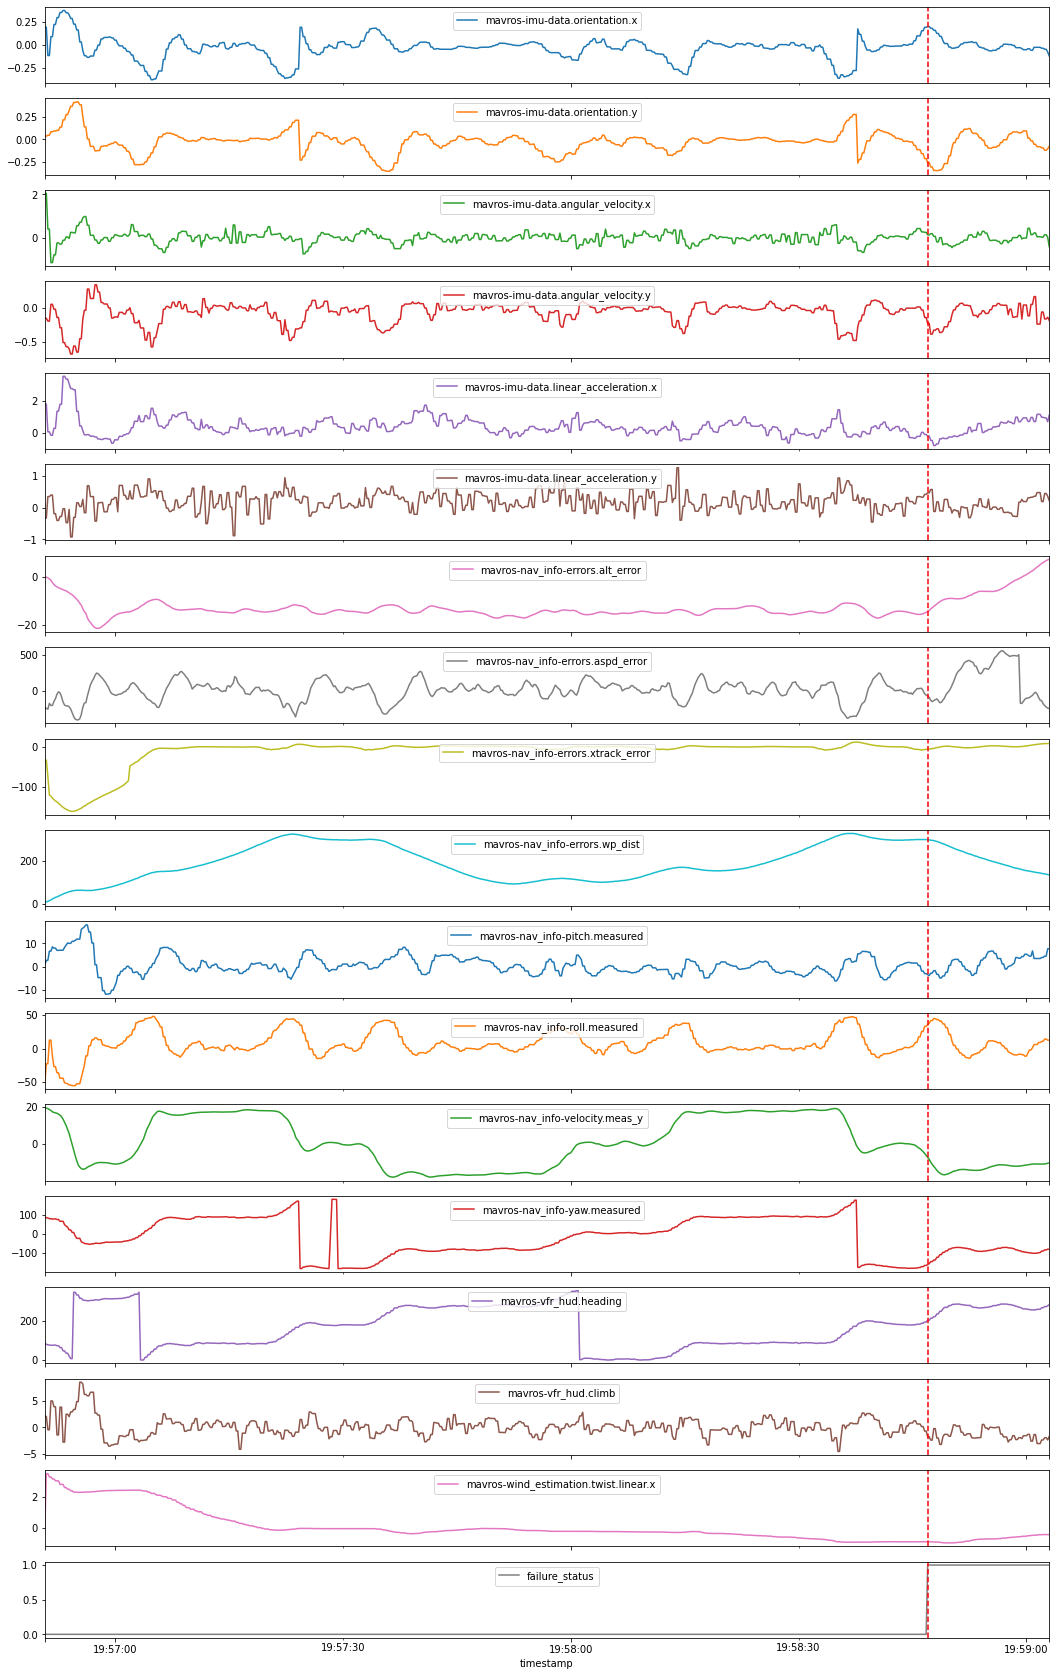

In [6]:
for flight_name in list(df_dict.keys())[0:1]:
    if "engine_failure" not in flight_name:
        continue
    status_file = flight_name + "-failure_status-engines.csv"
    
    failure_status = read_data(os.path.join(data_path, flight_name, status_file))
    failure_status = failure_status.resample("200ms").last()
    failure_status = failure_status.rename(columns={"field.data": "failure_status"})
    
    df_1 = df_dict[flight_name]
    df_1 = df_1.merge(failure_status, left_index=True, right_index=True, how="outer")
    df_1.iloc[0] = df_1.iloc[0].fillna(0)
    df_1 = df_1.pad()
    df_1["failure_status"] = df_1["failure_status"].astype(int)
       
    axes = df_1.plot(subplots=True, figsize=(18, 30));
    idx = df_1["failure_status"].ne(0).idxmax()

    #Loop over all axis objects and create a vertical line in each of them and set legend location
    for ax in axes:
        ax.axvline(idx, color="red", linestyle="--")
        ax.legend(loc='upper center')
    plt.show()

In [8]:
df_1.columns

Index(['mavros-imu-data.orientation.x', 'mavros-imu-data.orientation.y',
       'mavros-imu-data.angular_velocity.x',
       'mavros-imu-data.angular_velocity.y',
       'mavros-imu-data.linear_acceleration.x',
       'mavros-imu-data.linear_acceleration.y',
       'mavros-nav_info-errors.alt_error', 'mavros-nav_info-errors.aspd_error',
       'mavros-nav_info-errors.xtrack_error', 'mavros-nav_info-errors.wp_dist',
       'mavros-nav_info-pitch.measured', 'mavros-nav_info-roll.measured',
       'mavros-nav_info-velocity.meas_y', 'mavros-nav_info-yaw.measured',
       'mavros-vfr_hud.heading', 'mavros-vfr_hud.climb',
       'mavros-wind_estimation.twist.linear.x', 'failure_status'],
      dtype='object')

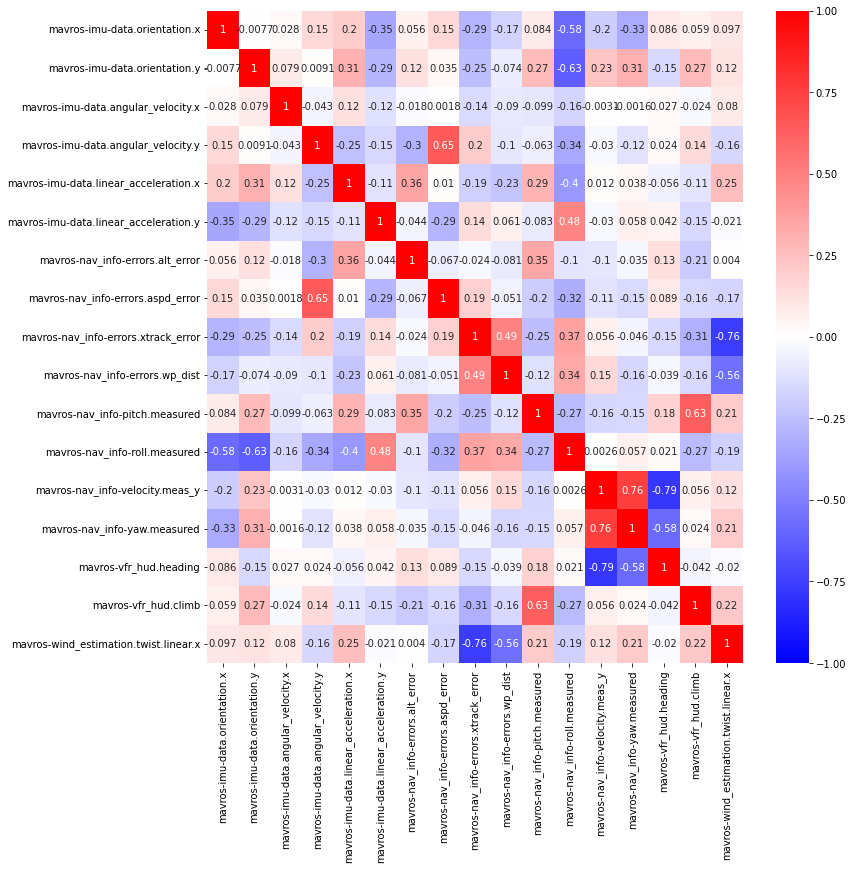

In [9]:
fig1 = plt.figure(figsize=(12, 12))
corr = df_1.corr(method="pearson")
sns.heatmap(corr, vmin=-1.0, vmax=1.0, cmap="bwr", annot=True)
plt.show()

In [9]:
from sklearn.feature_selection import mutual_info_classif

X = df_1.drop(["failure_status"], axis=1)
y = df_1["failure_status"].copy()
y = y.values

y[y>0] = 1
y[y<0] = 0

mi = mutual_info_classif(
    X=X,
    y=y,
    random_state=42
)

print("Estimated mutual information for each feature:")

display(mi)

Estimated mutual information for each feature:


array([0.11094547, 0.10311741, 0.09925589, 0.08191442, 0.11876175,
       0.07454964, 0.23002547, 0.17560637, 0.0523797 , 0.01758232,
       0.09039072, 0.07842228, 0.21609846, 0.25299099, 0.24312522,
       0.13718871, 0.19243344])

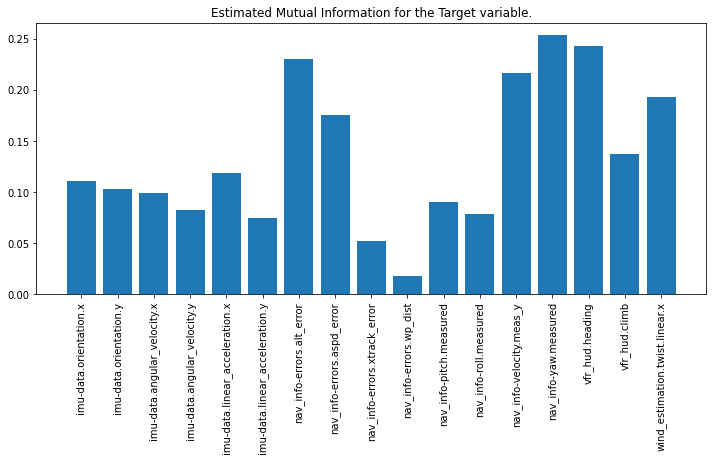

In [10]:
x_labels = list(map(lambda x: x[7:], X.columns))

fig1 = plt.figure(figsize=(12, 5))
plt.bar(x_labels, height=mi)

plt.title("Estimated Mutual Information for the Target variable.")
plt.xticks(rotation = 90)
plt.show()